# Forecast EUR/USD using VAR and ARIMA

•	**Data:** We use daily data on EUR/USD, 10yr EU Bund yields, 10yr UST yields, oil prices (WTI), and gold prices (XAU) for the period Jan 4, 2000 – Sep 11, 2023 sourced by Reuters Refinitiv. All data are stationary after taking first differences, according to the ADF test.

•	**Model:** At first, we fit a VAR(p) model with the variables mentioned above. The order p is defined using the minimum AIC for $0 <= p <= 10$. We estimate daily forecasts considering nine different windows: 5, 11, 22, 35, 44, 55, 63, 130 and 260 days. We test the last d observations of each sample (where $d$ is the number of days of forecast) after training the first $n-d$ (where $n$ is the total number of days) observations. Afterwards we compare the results with a fitted ARIMA (0,1,0) process, with $p=0$ and $q=0$ defined after observing the autocorrelation and partial autocorrelation (ACF and PACF) functions and $d=1$ because stationarity holds at first differences. To test forecasting accuracy for each forecast window, we use the Mean Absolute Percentage Error (MAPE) criterion:

$$MAPE = \frac{1}{d} \sum^n_{t=1} \frac{|x_t - \hat{x}_t|}{x_t}$$

where $x_t$ is the actual value of EUR/USD, $\hat{x}_t$ is the forecast at time $t$ and $d$ is the number of days of forecast.

•	**Results**: Figure 1 presents daily forecasts of EUR/USD under the VAR and ARIMA for each forecast window, compared with the actual value. Table 1 and Table 2 present the mean value of forecasts and the MAPE criterion for each forecast window under the VAR and ARIMA model respectively. According to the results, the optimal performance of VAR is for a forecast window of 35 days, with MAPE showing a discrepancy between the actual and the projected value by 0.8%. This is also the only forecast window were MAPE for mean forecasts is smaller in the case of VAR compared to the ARIMA forecasts (Figure 2), indicating that overall ARIMA performs better in most cases.

**Figure 1: Daily forecasts of EUR/USD for each forecast window** 

![forecasts](assets/forecasts_daily.png)

**Table 1: Mean value of EUR/USD VAR forecasts and relevant MAPE tests**

| Days of forecast | EUR/USD | EUR/USD forecast with VAR | MAPE |
| --- | --- | --- | --- |
| 5 | 1.07186 | 1.059896 | 0.011157 |
| 11 | 1.078409 | 1.049221 | 0.027099 | 
| 22 | 	1.083495 | 	1.118707 | 	0.032624 |
| 35 | 1.089569 | 	1.098181 | 	0.007997 |
| 44 | 1.095098 | 	1.189629 | 	0.088318 |
| 55 | 1.094355 | 	1.016738 | 	0.071172 |
| 63 | 1.093663 | 	0.947646 | 	0.133661 | 
| 130 | 1.088331 | 	0.70005	| 0.355931 | 
| 260 | 1.059955 | 	-0.02289 |	1.002797 | 

**Table 2: Mean value of EUR/USD ARIMA forecasts and relevant MAPE tests**

| Days of forecast | EUR/USD | EUR/USD forecast with ARIMA | MAPE |
| --- | --- | --- | --- |
| 5 | 1.07186 | 1.077324 | 0.005101 | 
| 11 | 1.078409 | 1.080952 | 0.006103 |
| 22 | 1.083495 | 1.097431	| 0.012964 |
| 35 | 1.089569 | 1.112552	| 0.021189 |
| 44 | 1.095098	| 1.100168	| 0.011798 |
| 55 | 1.094355	| 1.095913	| 0.00974 |
| 63 | 1.093663	| 1.074943	| 0.01747 |
| 130 | 1.088331 | 1.05993	| 0.026128 |
| 260 | 1.059955 | 0.993243	| 0.064704 |

**Figure 2: MAPE criterion for mean forecasts using VAR and ARIMA**

![MAPE](assets/MAPE.png)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import os


data = r"C:\Users\jim\Dropbox\Sample projects\Forecasting\data"


C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import data

#### Import EURUSD


In [2]:
df = pd.read_csv(rf'{data}\EURUSD daily.csv')
df = df.iloc[6420:]
df.rename(columns = {'Last':'EURUSD'}, inplace = True)
df['date'] = pd.to_datetime(df['Date'])
df = df[["date", "EURUSD"]]
df.reset_index(drop=True, inplace=True)
eur_usd = df.copy()
eur_usd.head()

,date,EURUSD
0,2000-01-03,1.0262
1,2000-01-04,1.0308
2,2000-01-05,1.0314
3,2000-01-06,1.0319
4,2000-01-07,1.0289


#### Import EU10yr Bund yields

In [3]:
df = pd.read_csv(rf'{data}\10yr Bund yields.csv')
df = df.iloc[274:]
df.rename(columns = {'Last':'EU10yr'}, inplace = True)
df['date'] = pd.to_datetime(df['Date'])
df = df[["date", "EU10yr"]]
df.reset_index(drop=True, inplace=True)
eu10yr = df.copy()
eu10yr.head()

,date,EU10yr
0,2000-01-03,5.4708
1,2000-01-04,5.4801
2,2000-01-05,5.4801
3,2000-01-06,5.5402
4,2000-01-07,5.4256


#### Import UST yields


In [4]:
df = pd.read_csv(rf'{data}\10yr UST yields.csv')
df = df.iloc[9914:]
df.rename(columns = {'DGS10':'UST10yr', 'DATE': 'Date'}, inplace = True)
df['date'] = pd.to_datetime(df['Date'])
df = df[["date", "UST10yr"]]
df.loc[df['UST10yr'] == ".", 'UST10yr'] = ""
df['UST10yr'] = pd.to_numeric(df['UST10yr'])
df.reset_index(drop=True, inplace=True)
ust10yr = df.copy()
ust10yr.head()

,date,UST10yr
0,2000-01-03,6.58
1,2000-01-04,6.49
2,2000-01-05,6.62
3,2000-01-06,6.57
4,2000-01-07,6.52


#### Import oil prices (WTI)

In [5]:
df = pd.read_csv(rf'{data}\WTI.csv')
df = df.iloc[4209:]
df.rename(columns = {'Last':'WTI'}, inplace = True)
df['date'] = pd.to_datetime(df['Date'])
df = df[["date", "WTI"]]
df.reset_index(drop=True, inplace=True)
wti = df.copy()
wti.head()

,date,WTI
0,2000-01-04,25.55
1,2000-01-05,24.91
2,2000-01-06,24.78
3,2000-01-07,24.22
4,2000-01-10,24.67


#### Import gold prices (XAU)

In [6]:
df = pd.read_csv(rf'{data}\XAU.csv', header=1)
df.rename(columns = {'Last(QXAU=)':'XAU'}, inplace = True)
df = df.iloc[::-1]
df['date'] = pd.to_datetime(df['Date'])
df = df[["date", "XAU"]]
df = df[df["date"]>="2000-01-01"]
df["XAU"] = df["XAU"].str.replace(',', '')
df["XAU"] = df["XAU"].astype(float)
df.reset_index(drop=True, inplace=True)
xau = df.copy()
xau.head()

,date,XAU
0,2000-01-03,288.50
1,2000-01-04,282.20
2,2000-01-05,280.75
3,2000-01-06,280.85
4,2000-01-07,281.50


# Merge and construct core dataset

In [7]:
print(len(eur_usd))
print(len(eu10yr))
print(len(ust10yr))
print(len(wti))
print(len(xau))

core = eur_usd.merge(eu10yr, how = "inner", on = "date")
core = core.merge(ust10yr, how = "inner", on = "date")
core = core.merge(wti, how = "inner", on = "date")
core = core.merge(xau, how = "inner", on = "date")

print(len(core))
#rcParams['figure.figsize'] = 15, 7
#core.plot()
core.head()


6181
6070
6181
5957
6171
5894


,date,EURUSD,EU10yr,UST10yr,WTI,XAU
0,2000-01-04,1.0308,5.4801,6.49,25.55,282.20
1,2000-01-05,1.0314,5.4801,6.62,24.91,280.75
2,2000-01-06,1.0319,5.5402,6.57,24.78,280.85
3,2000-01-07,1.0289,5.4256,6.52,24.22,281.50
4,2000-01-10,1.0253,5.3938,6.57,24.67,281.10


### Check if series is stationary

In [8]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(eurusd):
    result=adfuller(eurusd)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis,indicating it is non-stationary ")

In [9]:
df = core.copy()
df = df.dropna()
df.reset_index(inplace=True, drop=True)
df.set_index('date', inplace=True)

x1 = "EURUSD"
x2 = "EU10yr"
x3 = "UST10yr"
x4 = "WTI"
x5 = "XAU"

xvars = (x1, x2, x3, x4, x5)
df = df[[x1, x2, x3, x4, x5]]

df_difference = df.diff()
df_difference = df_difference.dropna()

for x in xvars:
    print("Stationarity test: levels for", x)
    adfuller_test(df[x])
    print(" ")  
    print("Stationarity test: first difference for", x)
    # Take first difference
    adfuller_test(df_difference[x].dropna())
    print(" ")

Stationarity test: levels for EURUSD
ADF Test Statistic : -1.8465035172984363
p-value : 0.357630414399961
#Lags Used : 11
Number of Observations : 5836
Weak evidence against null hypothesis,indicating it is non-stationary 
 
Stationarity test: first difference for EURUSD
ADF Test Statistic : -23.046497038434595
p-value : 0.0
#Lags Used : 10
Number of Observations : 5836
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
 
Stationarity test: levels for EU10yr
ADF Test Statistic : -1.7245904469460218
p-value : 0.41848934041172203
#Lags Used : 0
Number of Observations : 5847
Weak evidence against null hypothesis,indicating it is non-stationary 
 
Stationarity test: first difference for EU10yr
ADF Test Statistic : -75.4620117396885
p-value : 0.0
#Lags Used : 0
Number of Observations : 5846
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
 
Stationarity test: levels for UST10yr
ADF Test Statistic : -

### Train-Test Split and Grid Search for Order p, and forecast using VAR(p)

In [10]:
def minimum(a,b):
    if a<=b:
        return a
    else:
        return b

C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

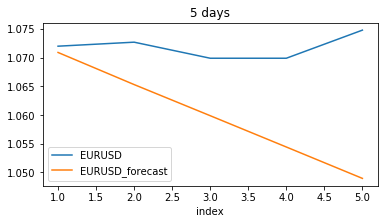

C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

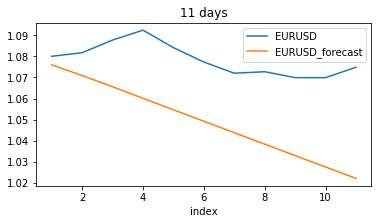

C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

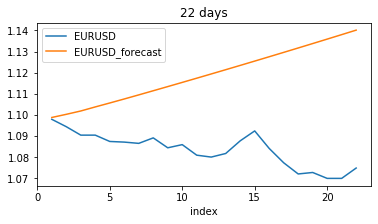

C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

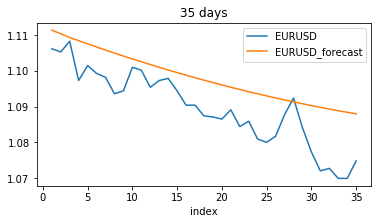

C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

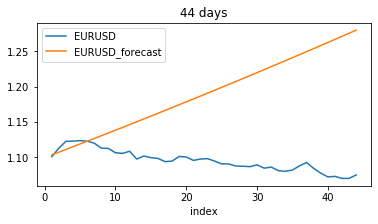

C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

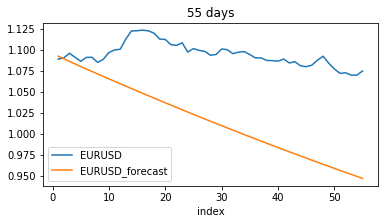

C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

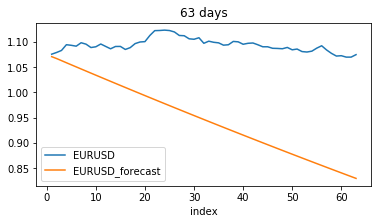

C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

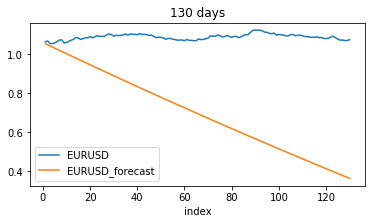

C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

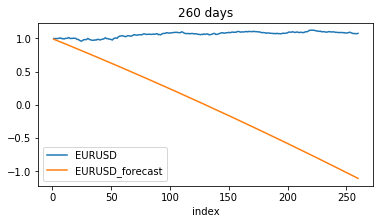

In [11]:
#Forecast the next x days (where x=test_obs)
test_obs = [5, 11, 22, 35, 44, 55, 63, 130, 260]
means = pd.DataFrame(index=np.arange(len(test_obs)), columns=np.arange(4))
means.rename(columns = {0:'Forecast_days' , 1:'EURUSD', 2: 'EURUSD_forecast', 3: 'MAPE'}, inplace = True)
r = 0
var_results = {}
daily_forecasts = {}
output_var = r'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\VAR\VAR daily'
df.reset_index(inplace=True, drop=True)

for t in test_obs:
    train = df_difference[:-t]
    test = df_difference[-t:]
    min_aic = np.nan
    
    for i in range(11):
        model = VAR(train)
        results = model.fit(i)
       # print('Order =', i)
       # print('AIC: ', results.aic)
       # print('BIC: ', results.bic)
        min_aic = minimum(min_aic, results.aic)
        if min_aic == results.aic:
            p = i  
            
    result = model.fit(p)
   # print(result.summary())
    var_results[r] = f'{t} days Forecast', result.summary()
    lagged_Values = train.values[-p:]
    pred = result.forecast(y=lagged_Values, steps=t)     
    df_forecast=pd.DataFrame(data=pred, columns=[x1 + '_2d', x2 + '_2d', x3 + '_2d', x4 + '_2d', x5 + '_2d'])

    for x in xvars:
        df_forecast[x + '_1d'] = (df[x].iloc[-t-1]-df[x].iloc[-t-2]) + df_forecast[x + '_2d'].cumsum()
        df_forecast[x + '_forecast'] = df[x].iloc[-t-1] + df_forecast[x + '_1d'].cumsum()
        
    test_original = df[-t:]
   # test_original.index = pd.to_datetime(test_original.index)    
    test_original.reset_index(inplace=True, drop=True)
    df_forecast["date"] = df_forecast.index
    test_original["date"] = test_original.index    

    var = x1
    df_forecast[var + "_MAPE"] = np.nan
    for i in range(t):
        df_forecast[var + "_MAPE"][i] = np.mean(np.abs(df_forecast[var + "_forecast"][i] - test_original[var][i])/np.abs(test_original[var][i]))
    
    daily_forecasts[r] = pd.merge(df_forecast[["EURUSD_forecast", "EURUSD_MAPE"]],test_original[["EURUSD"]], left_index=True,right_index=True) 
    daily_forecasts[r]["Day"] = daily_forecasts[r].index + 1
    daily_forecasts[r] = daily_forecasts[r][["Day", "EURUSD", "EURUSD_forecast", "EURUSD_MAPE"]] 
    
    means["Forecast_days"][r] = t
    means["EURUSD"][r] = test_original[var].mean()
    means["EURUSD_forecast"][r] = df_forecast[var + "_forecast"].mean()
    means["MAPE"][r] = np.mean(np.abs(df_forecast[var + "_forecast"] - test_original[var])/np.abs(test_original[var]))
    
    test_original["index"] = test_original.index + 1
    test_original.set_index('index', inplace=True)
    df_forecast["index"] = df_forecast.index + 1
    df_forecast.set_index('index', inplace=True)
    test_original[x1].plot(figsize=(6,3),legend=True)
    df_forecast[x1 + '_forecast'].plot(legend=True)
    plt.legend()
    plt.title(f'{t} days')
    file_name = f'plot_{t}_days_forecast.png'
    file_path = os.path.join(output_var, file_name)
    plt.savefig(file_path)
    plt.show()
    
    r=r+1
    
means.head() 

dataframes = [daily_forecasts[0], 
              daily_forecasts[1],
              daily_forecasts[2],
              daily_forecasts[3],
              daily_forecasts[4],
              daily_forecasts[5],
              daily_forecasts[6],
              daily_forecasts[7],
              daily_forecasts[8]]

with pd.ExcelWriter(rf'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\VAR\VAR daily\EURUSD_VAR.xlsx', engine='openpyxl') as writer:
     for i, daily_forecasts[r] in enumerate(dataframes, start=1):
        sheet_name = f'{len(daily_forecasts[r])} days forecast'
        daily_forecasts[r].to_excel(writer, sheet_name=sheet_name, index=False)      
        
   
     sheet_name = 'Mean forecasts'
     means.to_excel(writer, sheet_name=sheet_name, index=False)      

var_results = pd.DataFrame(var_results)
var_results.to_excel(rf'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\VAR\VAR daily\VAR_summary.xlsx')        

# ARIMA

Forecasts ahead: 5
Forecasts ahead: 11
Forecasts ahead: 22
Forecasts ahead: 35
Forecasts ahead: 44
Forecasts ahead: 55
Forecasts ahead: 63
Forecasts ahead: 130
Forecasts ahead: 260


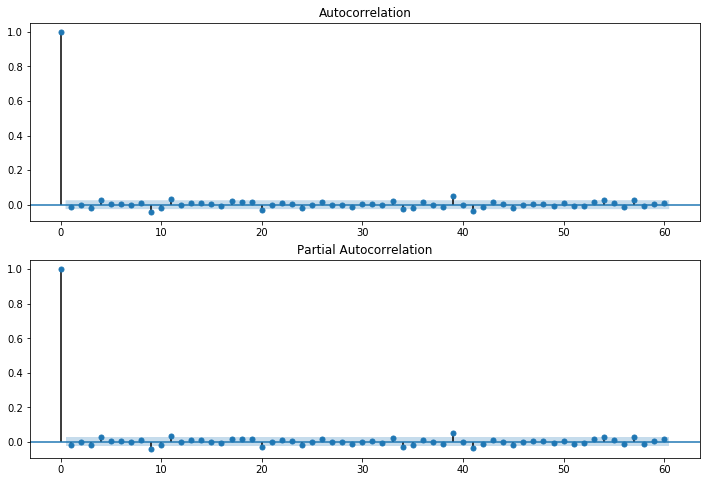

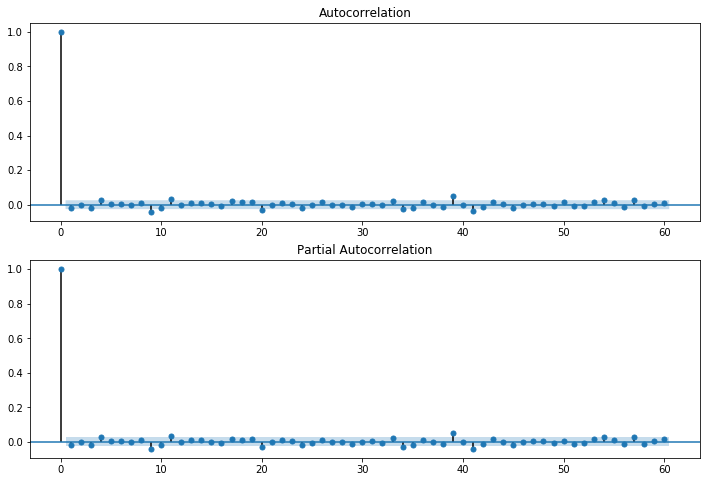

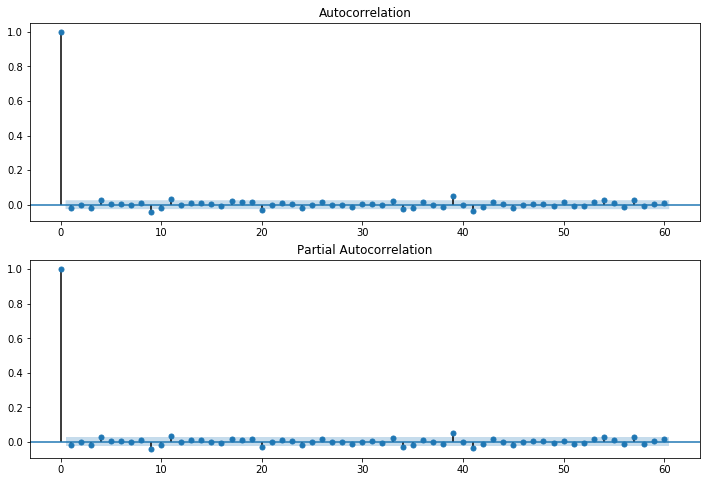

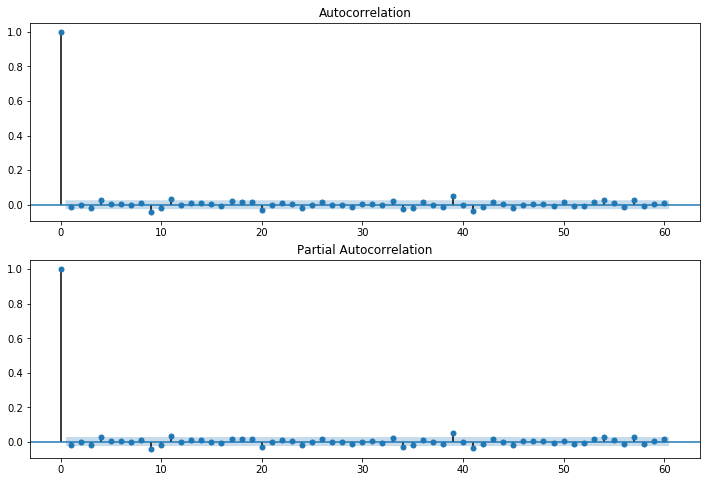

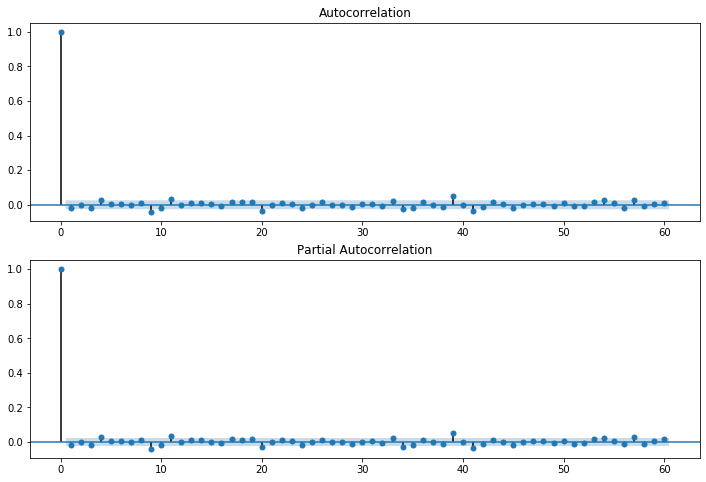

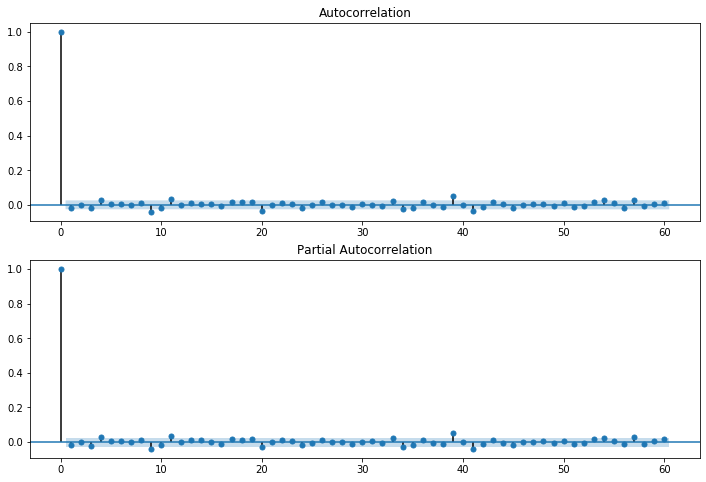

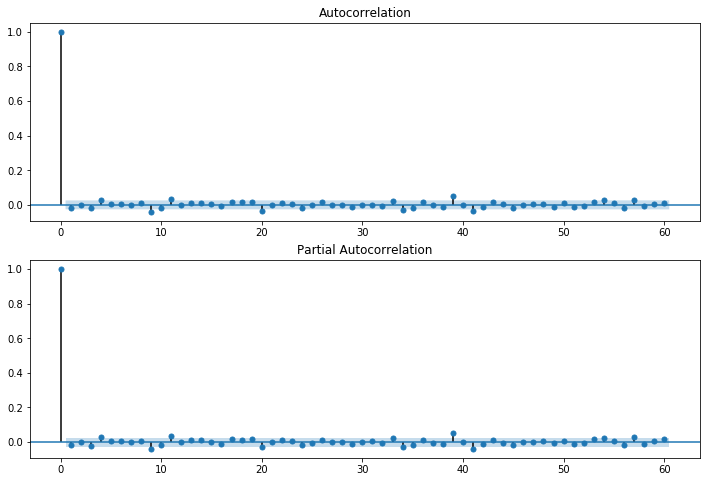

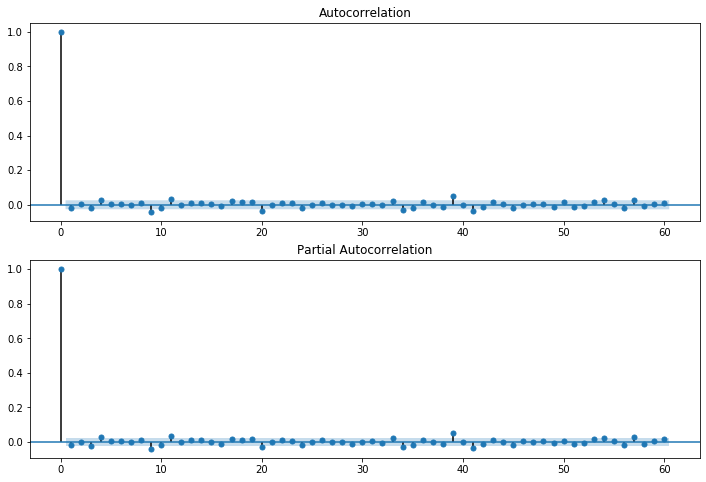

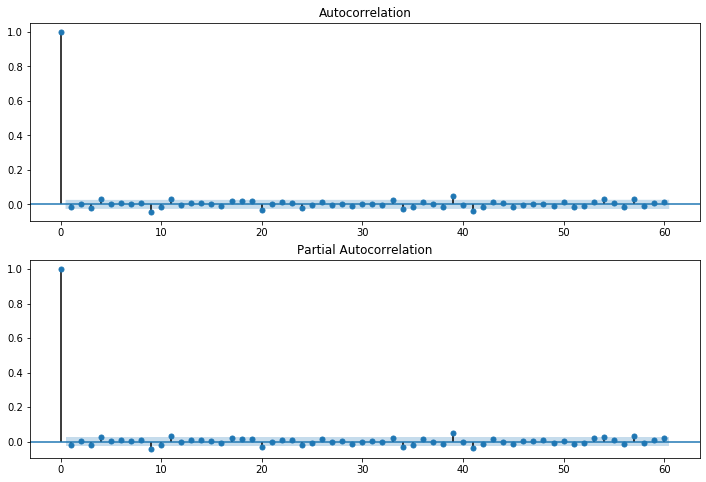

In [12]:
test_obs = [5, 11, 22, 35, 44, 55, 63, 130, 260]

for t in test_obs:
    print("Forecasts ahead:", t)
    train = df_difference['EURUSD'][:-t]
    test = df_difference['EURUSD'][-t:]
    
    lags = 60
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(train.dropna(),lags=lags,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(train.dropna(),lags=lags,ax=ax2)

                             ARIMA Model Results                              
Dep. Variable:               D.EURUSD   No. Observations:                 5842
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20423.966
Method:                           css   S.D. of innovations              0.007
Date:                Mon, 16 Oct 2023   AIC                         -40843.931
Time:                        19:54:41   BIC                         -40830.586
Sample:                             1   HQIC                        -40839.291
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.96e-06    9.6e-05      0.083      0.934      -0.000       0.000


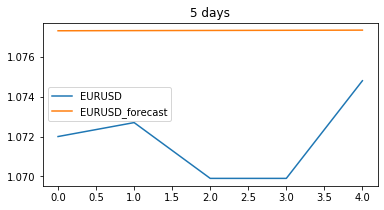

                             ARIMA Model Results                              
Dep. Variable:               D.EURUSD   No. Observations:                 5836
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20401.634
Method:                           css   S.D. of innovations              0.007
Date:                Mon, 16 Oct 2023   AIC                         -40799.268
Time:                        19:54:42   BIC                         -40785.925
Sample:                             1   HQIC                        -40794.628
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.584e-06    9.6e-05      0.089      0.929      -0.000       0.000


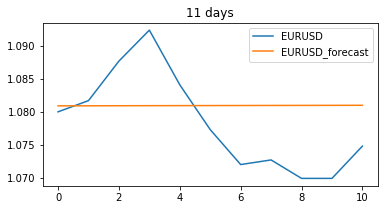

                             ARIMA Model Results                              
Dep. Variable:               D.EURUSD   No. Observations:                 5825
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20358.561
Method:                           css   S.D. of innovations              0.007
Date:                Mon, 16 Oct 2023   AIC                         -40713.122
Time:                        19:54:43   BIC                         -40699.783
Sample:                             1   HQIC                        -40708.483
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.142e-05   9.62e-05      0.119      0.906      -0.000       0.000


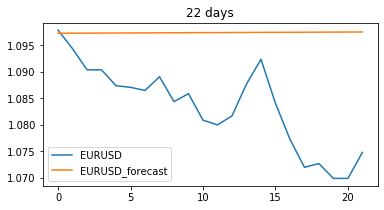

                             ARIMA Model Results                              
Dep. Variable:               D.EURUSD   No. Observations:                 5812
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20309.269
Method:                           css   S.D. of innovations              0.007
Date:                Mon, 16 Oct 2023   AIC                         -40614.537
Time:                        19:54:43   BIC                         -40601.202
Sample:                             1   HQIC                        -40609.899
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.402e-05   9.64e-05      0.145      0.884      -0.000       0.000


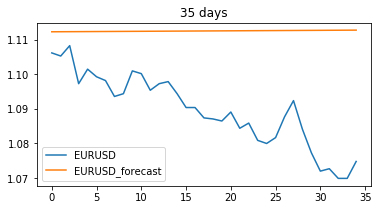

                             ARIMA Model Results                              
Dep. Variable:               D.EURUSD   No. Observations:                 5803
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20276.093
Method:                           css   S.D. of innovations              0.007
Date:                Mon, 16 Oct 2023   AIC                         -40548.186
Time:                        19:54:44   BIC                         -40534.854
Sample:                             1   HQIC                        -40543.548
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.191e-05   9.65e-05      0.123      0.902      -0.000       0.000


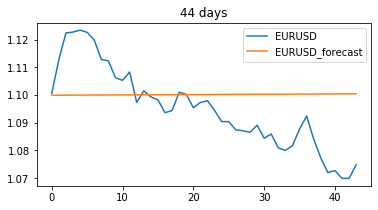

                             ARIMA Model Results                              
Dep. Variable:               D.EURUSD   No. Observations:                 5792
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20234.629
Method:                           css   S.D. of innovations              0.007
Date:                Mon, 16 Oct 2023   AIC                         -40465.258
Time:                        19:54:44   BIC                         -40451.929
Sample:                             1   HQIC                        -40460.621
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.119e-05   9.66e-05      0.116      0.908      -0.000       0.000


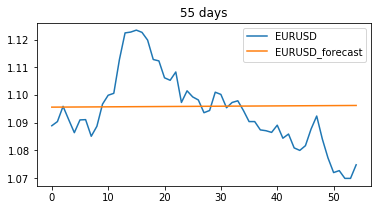

                             ARIMA Model Results                              
Dep. Variable:               D.EURUSD   No. Observations:                 5784
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20204.683
Method:                           css   S.D. of innovations              0.007
Date:                Mon, 16 Oct 2023   AIC                         -40405.366
Time:                        19:54:44   BIC                         -40392.040
Sample:                             1   HQIC                        -40400.730
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.59e-06   9.67e-05      0.078      0.937      -0.000       0.000


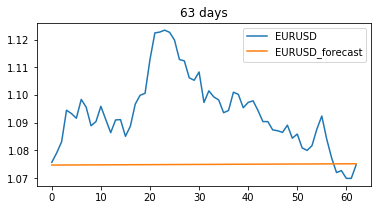

                             ARIMA Model Results                              
Dep. Variable:               D.EURUSD   No. Observations:                 5717
Model:                 ARIMA(0, 1, 0)   Log Likelihood               19953.837
Method:                           css   S.D. of innovations              0.007
Date:                Mon, 16 Oct 2023   AIC                         -39903.674
Time:                        19:54:45   BIC                         -39890.372
Sample:                             1   HQIC                        -39899.044
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.037e-06   9.76e-05      0.052      0.959      -0.000       0.000


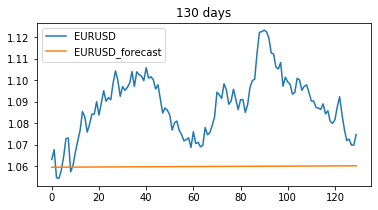

                             ARIMA Model Results                              
Dep. Variable:               D.EURUSD   No. Observations:                 5587
Model:                 ARIMA(0, 1, 0)   Log Likelihood               19490.189
Method:                           css   S.D. of innovations              0.007
Date:                Mon, 16 Oct 2023   AIC                         -38976.377
Time:                        19:54:45   BIC                         -38963.121
Sample:                             1   HQIC                        -38971.757
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.569e-06   9.89e-05     -0.066      0.947      -0.000       0.000


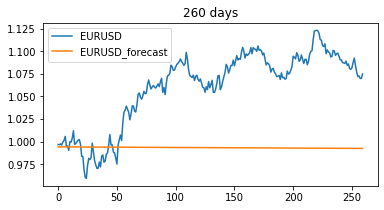

In [13]:
#According to the ACF and PACF plots, we select p=0 and q=0
p_arima = 0
d_arima = 1
q_arima = 0
obs = len(df)
r = 0
pr_tr = {}
means_arima = pd.DataFrame(index=np.arange(len(test_obs)), columns=np.arange(4))
means_arima.rename(columns = {0:'Forecast_days' , 1:'EURUSD', 2: 'EURUSD_forecast', 3: 'MAPE'}, inplace = True)
output_arima = r'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\ARIMA\ARIMA daily'


for t in test_obs:   
    a = obs-t

    #adfuller_test(df['EURUSD First Difference'][:a].dropna())
    model = ARIMA(df['EURUSD'][:a],order=(p_arima,d_arima,q_arima))
    results = model.fit()
    print(results.summary())
   
    y_pred = pd.Series(results.forecast(t)[0], index=df["EURUSD"][a:].index)
    y_true = df["EURUSD"][a:]
  
    pred = y_pred.to_frame() 
    pred.rename(columns = {0:'EURUSD_forecast'}, inplace = True)
    true = y_true.to_frame()
        
    pr_tr[r] = pd.merge(pred, true, left_index=True, right_index=True)
    pr_tr[r].reset_index(inplace=True, drop=True)
    pr_tr[r]["EURUSD_MAPE"] = np.nan
    
    for i in range(t):
        pr_tr[r]["EURUSD_MAPE"][i] = np.mean(np.abs(pr_tr[r]['EURUSD_forecast'][i] - pr_tr[r]['EURUSD'][i])/np.abs(pr_tr[r]['EURUSD'][i]))
    
    means_arima["Forecast_days"][r] = t
    means_arima["EURUSD"][r] = pr_tr[r]["EURUSD"].mean()
    means_arima["EURUSD_forecast"][r] = pr_tr[r]["EURUSD_forecast"].mean()
    means_arima["MAPE"][r] = pr_tr[r]["EURUSD_MAPE"].mean()
    
    pr_tr[r]["Day"] = pr_tr[r].index + 1
   # pr_tr[r].set_index('index', inplace=True)
    pr_tr[r]["EURUSD"].plot(figsize=(6,3),legend=True)
    pr_tr[r]["EURUSD_forecast"].plot(legend=True)   
    pr_tr[r] = pr_tr[r][["Day", "EURUSD", "EURUSD_forecast", "EURUSD_MAPE"]] 
    
    plt.legend()
    plt.title(f'{t} days')
    file_name = f'plot_{t}_days_forecast.png'
    file_path = os.path.join(output_arima, file_name)
    plt.savefig(file_path)
    plt.show()    
    
    r = r + 1

means_arima.head() 

dataframes = [pr_tr[0], 
              pr_tr[1],
              pr_tr[2],
              pr_tr[3],
              pr_tr[4],
              pr_tr[5],
              pr_tr[6],
              pr_tr[7],
              pr_tr[8]]

with pd.ExcelWriter(rf'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\ARIMA\ARIMA daily\EURUSD_ARIMA.xlsx', engine='openpyxl') as writer:
     for i, pr_tr[r] in enumerate(dataframes, start=1):
        sheet_name = f'{len(pr_tr[r])} days forecast'
        pr_tr[r].to_excel(writer, sheet_name=sheet_name, index=False)    
   
     sheet_name = 'Mean forecasts'
     means_arima.to_excel(writer, sheet_name=sheet_name, index=False)         



C:\Users\jim\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\jim\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\jim\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


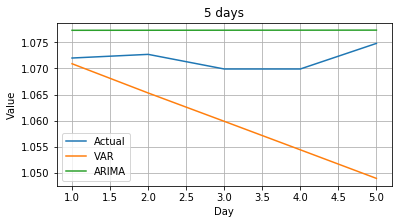

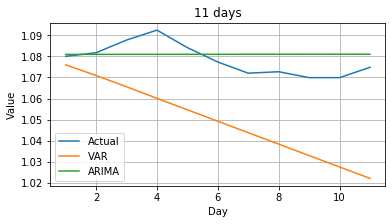

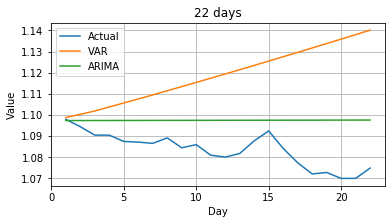

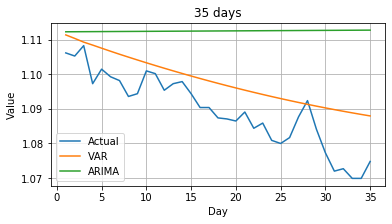

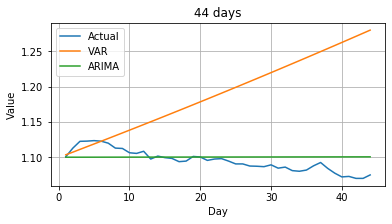

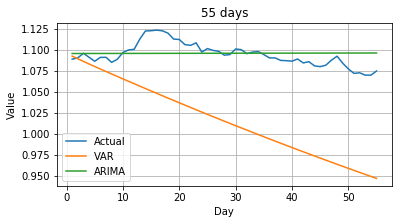

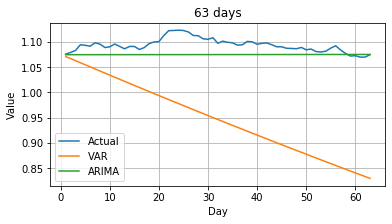

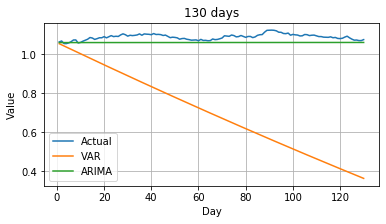

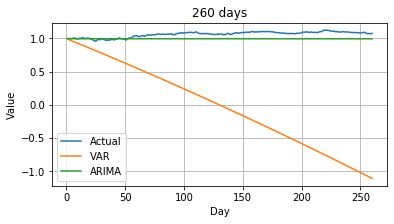

In [14]:
forecasts_eurusd = {}
output_all = r'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\All models'

for r in range(0,9):
    forecasts_eurusd[r] = daily_forecasts[r].copy()
    forecasts_eurusd[r] = forecasts_eurusd[r][["Day", "EURUSD", "EURUSD_forecast"]]
    forecasts_eurusd[r].rename(columns = {'EURUSD':'Actual', 'EURUSD_forecast':'VAR'}, inplace = True)
    forecasts_eurusd[r] = forecasts_eurusd[r].merge(pr_tr[r][["Day", "EURUSD_forecast"]], how = "inner", on = "Day")
    forecasts_eurusd[r].rename(columns = {'EURUSD_forecast':'ARIMA'}, inplace = True)
    
    # Extract the data
    days = forecasts_eurusd[r]["Day"]
    actual = forecasts_eurusd[r]["Actual"]
    var = forecasts_eurusd[r]["VAR"]
    arima = forecasts_eurusd[r]["ARIMA"]

    # Create the plot
    plt.figure(figsize=(6, 3))  # Adjust the figure size as needed
    plt.plot(days, actual, label="Actual")
    plt.plot(days, var, label="VAR")
    plt.plot(days, arima, label="ARIMA")
    
    
    # Add labels and legend
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.title(f'{len(forecasts_eurusd[r])} days')
    file_name = f'plot_{len(forecasts_eurusd[r])}_days_forecast.png'
    file_path = os.path.join(output_all, file_name)
    plt.savefig(file_path)
    plt.show()